### Workspace

In [1]:
%matplotlib notebook

from modsim import *

In [2]:
altitude = [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 
            8000, 9000, 10000, 15000, 20000, 25000, 30000,
           40000, 50000, 60000, 70000, 80000]
density = [1.225, 1.112, 1.007, .9093, .8194, .7364, .6601,
          .5900, .5258, .4671, .4135, .1948, .08891, .04008,
          .01841, .003996, .001027, .0003097, .00008283, .000001846]

dd_da = TimeSeries()
for i in range(20):
    x = altitude[i]
    y = density[i]
    dd_da[x] = y

dd_da = interpolate(dd_da, kind='cubic')

In [3]:
condition = Condition(height=90000,
                      thrust_on=200,
                      f_thrust=20,
                      mass=1,
                      length=.1,
                      width=.1,
                      dd_da=dd_da,
                      C_d=1,
                      g=9.8,
                      dt=1,
                      t_end=500)

In [29]:
def make_system(condition):
    unpack(condition)
    
    init = State(height=height, velocity=0)
    
    drag_coef = -C_d*length*width / 2
    
    steps = (t_end)/dt + 1
    series = linspace(0,t_end, steps)
    
    system = System(init=init,
                    series=series,
                    dt=dt,
                    thrust_on=thrust_on,
                    f_thrust=f_thrust,
                    mass=mass,
                    drag_coef=drag_coef,
                    dd_da=dd_da,
                    t1=-1, t2=-1,
                    t_end = t_end)
    return system

def slope(state, system, dt, count):
    unpack(system)
    height, velocity = state
    
    if (height < thrust_on):
        f_t=f_thrust
    else:
        f_t=0
    
    f_drag = drag_coef * abs(velocity) * velocity * abs(dd_da(height))
    #print(f_drag)
    a_drag = f_drag/mass

    a_thrust = f_t/mass
    a_grav = -g
    a = a_grav + a_thrust + a_drag
    dV = a*dt
    velocity += dV
    
    dH = velocity*dt
    height += dH
    
    if(f_t > 0 and system.t1==-1 and a>0):
        system.t1=dt*count
    elif(a < 0 and system.t1 != -1 and system.t2 == -1):
        system.t2 = dt*count
        
    return State(height=height, velocity=velocity)

def run_ode_better(system, slope_func):
    count = 0
    unpack(system)
    frame = TimeFrame(columns=init.index)
    
    frame.loc[0] = init
    for i in series:
        if(i < t_end):
            frame.loc[i+dt] = slope_func(frame.loc[i], system, dt, count)
        else:
            system.results = frame
        count += 1
    system.count = count
    
def plot_height(results):
    newfig()
    unpack(results)
    
    plot(height, label='y')
        
    decorate(xlabel='Time (s)',
             ylabel='Position (m)')

    
def plot_velocity(results):
    newfig()
    unpack(results)
    
    plot(velocity, label='v')
    
    decorate(xlabel='Time (s)',
             ylabel='Velocity (m)')
    
def height_at_zero(system):
    unpack(system)
    velocity = system.results.velocity[t1:t2]
    time = velocity.idxmin()
    t = interp_inverse(velocity)
    
    #time = t(0)
    y = interpolate(system.results.height)
    height = y(time)
    return height

def run_simulation(t_on):
    system = make_system(condition)
    condition.set(thrust_on = t_on)
    run_ode_better(system, slope)
    #print(system.thrust_on)
    system.final_height = height_at_zero(system)
    
    return system

In [30]:
condition.set(dt=1)
condition.set(t_end = 300)
condition.set(height = 1000)

run1 = run_simulation(1000)

In [31]:
run1.final_height

array(990.2)

<IPython.core.display.Javascript object>


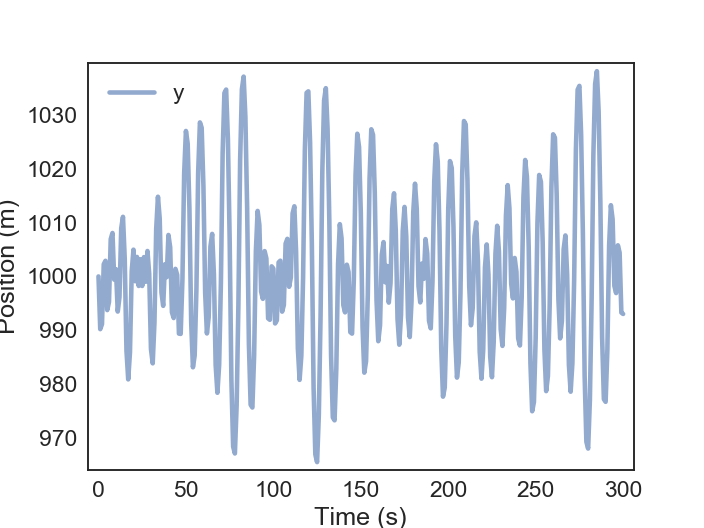

In [32]:
plot_height(run1.results)

<IPython.core.display.Javascript object>


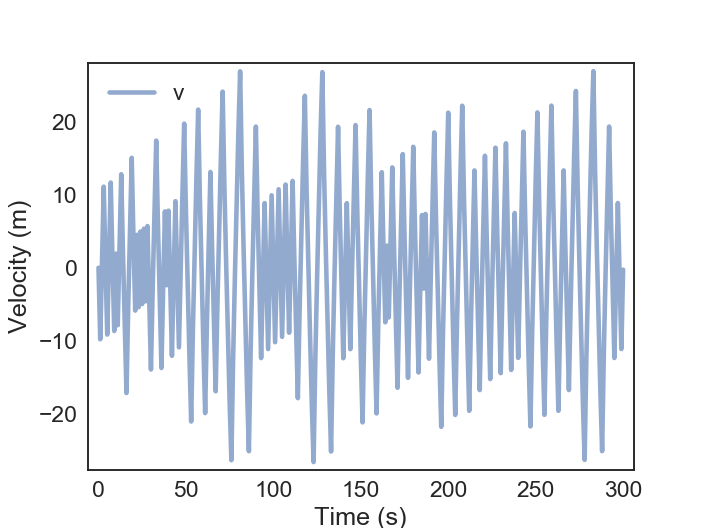

In [33]:
plot_velocity(run1.results)

In [34]:
sweep = SweepSeries()
condition.set(dt=1)
for thrust in linrange(1, 50, 1):
    system57 = run_simulation(thrust)
    print(system57.thrust_on)
    print(system57.final_height)
    #print(system57.t1)
    #print(system.results.height[system.t_end])
    sweep[thrust] = system57.final_height

1000
990.2
1.0
-19.360270569846442
2.0
-19.360270569846442
3.0
-19.360270569846442
4.0
-19.360270569846442
5.0
-19.360270569846442
6.0
-19.360270569846442
7.0
-19.360270569846442
8.0
-19.360270569846442
9.0
-19.360270569846442
10.0
-19.360270569846442
11.0
-19.360270569846442
12.0
-19.360270569846442
13.0
-19.360270569846442
14.0
-19.360270569846442
15.0
-19.360270569846442
16.0
-19.360270569846442
17.0
-19.360270569846442
18.0
-19.360270569846442
19.0
-19.360270569846442
20.0
-19.360270569846442
21.0
20.760492668951017
22.0
20.760492668951017
23.0
20.760492668951017
24.0
20.760492668951017
25.0
20.760492668951017
26.0
20.760492668951017
27.0
20.760492668951017
28.0
20.760492668951017
29.0
20.760492668951017
30.0
20.760492668951017
31.0
20.760492668951017
32.0
20.760492668951017
33.0
20.760492668951017
34.0
20.760492668951017
35.0
20.760492668951017
36.0
20.760492668951017
37.0
20.760492668951017
38.0
20.760492668951017
39.0
20.760492668951017
40.0
20.760492668951017
41.0
20.7604926689

<IPython.core.display.Javascript object>


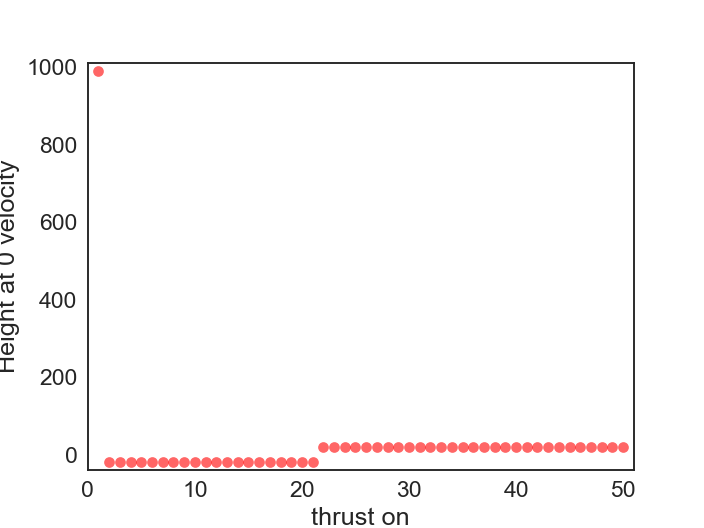

In [35]:
newfig()
plot(sweep, 'ro')
decorate(xlabel='thrust on',
         ylabel='Height at 0 velocity',
         legend=False)

In [72]:
sweep

,value
1,991.053141931469
2,-44.56418579808036
3,-44.56418579808036
4,-44.56418579808036
5,-44.56418579808036
6,-44.56418579808036
7,-44.56418579808036
8,-44.56418579808036
9,-44.56418579808036
10,-44.56418579808036


In [84]:
linrange(1, 50, 1)

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.])